In [2]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

In [3]:
import warnings
warnings.filterwarnings('ignore')

### A - i

In [25]:
def simulate_ar(n=200, phi=None, mu=0, sigma=1, y0=0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # Génération des erreurs i.i.d. N(0, sigma^2)
    errors = np.random.normal(0, sigma, n)
    
    # Initialisation
    if phi is None:
        phi = []
    else:
        phi = np.array(phi)
    
    p = len(phi)  # Ordre AR
    y = np.zeros(n)
    
    # Conditions initiales
    if isinstance(y0, (list, np.ndarray)):
        y[:p] = y0
    else:
        y[:p] = y0
    
    # Simulation AR(p): y_t = mu + phi1*y_{t-1} + ... + phip*y_{t-p} + e_t
    for t in range(p, n):
        y[t] = mu
        for i in range(p):
            y[t] += phi[i] * y[t-1-i]
        y[t] += errors[t]
    
    return y

print("Fonction simulate_ar définie avec succès!")

Fonction simulate_ar définie avec succès!


In [26]:
# Simulation des 5 séries AR avec la même graine pour reproductibilité
np.random.seed(42)

# Série 1: y_t = y_{t-1} + e_t (marche aléatoire)
y1 = simulate_ar(n=200, phi=[1.0], mu=0, seed=42)

# Série 2: y_t = 0.98*y_{t-1} + e_t
y2 = simulate_ar(n=200, phi=[0.98], mu=0, seed=43)

# Série 3: y_t = 0.90*y_{t-1} + e_t
y3 = simulate_ar(n=200, phi=[0.90], mu=0, seed=44)

# Série 4: y_t = 0.1 + y_{t-1} + e_t (marche aléatoire avec drift)
y4 = simulate_ar(n=200, phi=[1.0], mu=0.1, seed=45)

# Série 5: y_t = 1.25*y_{t-1} - 0.27*y_{t-2} + e_t
y5 = simulate_ar(n=200, phi=[1.25, -0.27], mu=0, seed=46)

print("Toutes les séries ont été simulées avec succès!")
print(f"\nSérie 1 (RW):          Min={y1.min():.2f}, Max={y1.max():.2f}, Finale={y1[-1]:.2f}")
print(f"Série 2 (AR φ=0.98):   Min={y2.min():.2f}, Max={y2.max():.2f}, Finale={y2[-1]:.2f}")
print(f"Série 3 (AR φ=0.90):   Min={y3.min():.2f}, Max={y3.max():.2f}, Finale={y3[-1]:.2f}")
print(f"Série 4 (RW+drift):    Min={y4.min():.2f}, Max={y4.max():.2f}, Finale={y4[-1]:.2f}")
print(f"Série 5 (AR(2)):       Min={y5.min():.2f}, Max={y5.max():.2f}, Finale={y5[-1]:.2f}")

Toutes les séries ont été simulées avec succès!

Série 1 (RW):          Min=-14.02, Max=3.98, Finale=-8.65
Série 2 (AR φ=0.98):   Min=-7.30, Max=8.64, Finale=4.11
Série 3 (AR φ=0.90):   Min=-5.16, Max=4.60, Finale=-2.15
Série 4 (RW+drift):    Min=-10.22, Max=16.41, Finale=13.50
Série 5 (AR(2)):       Min=-9.90, Max=15.89, Finale=6.60


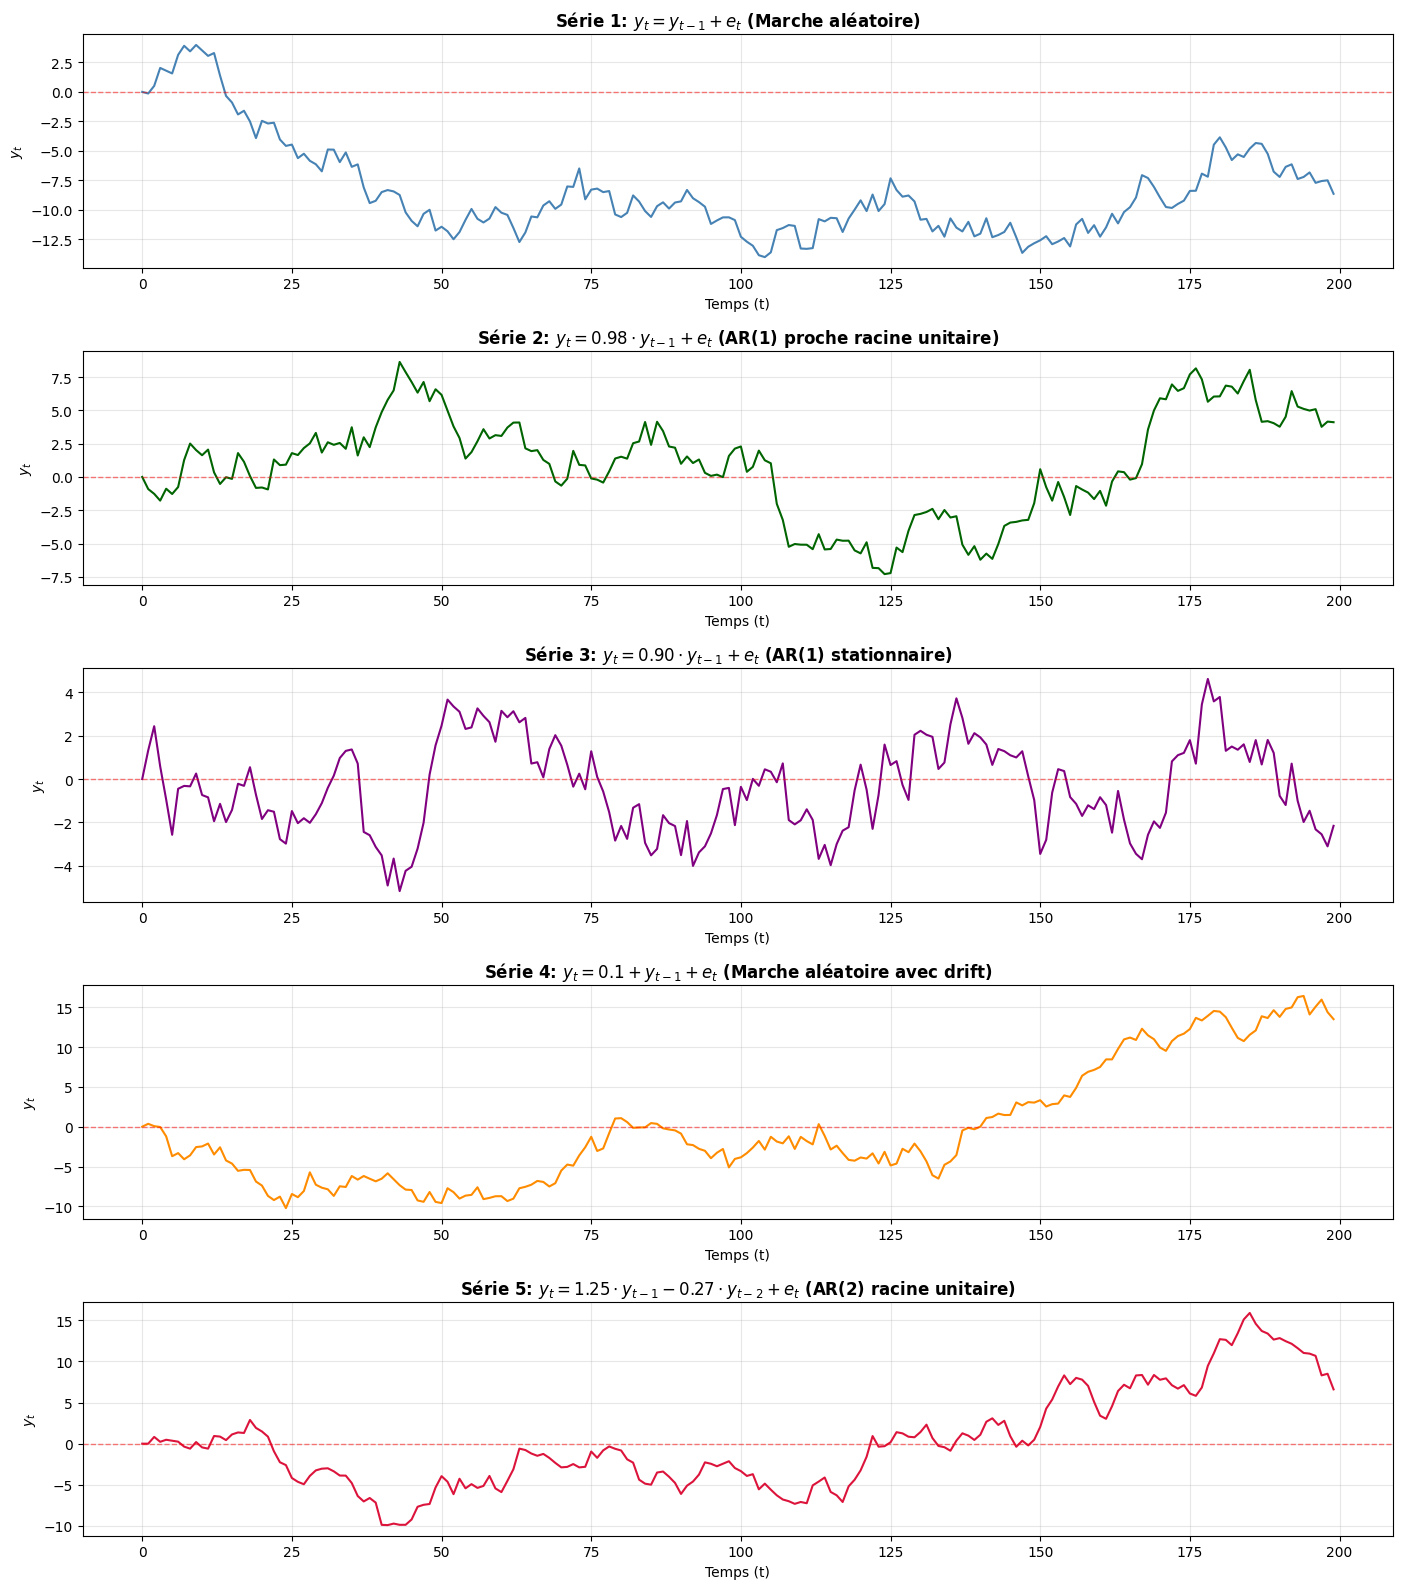

In [27]:
# Graphiques des 5 séries temporelles
fig, axes = plt.subplots(5, 1, figsize=(14, 16))

# Série 1: Marche aléatoire
axes[0].plot(y1, linewidth=1.5, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_title('Série 1: $y_t = y_{t-1} + e_t$ (Marche aléatoire)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Temps (t)', fontsize=10)
axes[0].set_ylabel('$y_t$', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Série 2: AR(1) avec φ=0.98
axes[1].plot(y2, linewidth=1.5, color='darkgreen')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title('Série 2: $y_t = 0.98 \cdot y_{t-1} + e_t$ (AR(1) proche racine unitaire)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Temps (t)', fontsize=10)
axes[1].set_ylabel('$y_t$', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Série 3: AR(1) avec φ=0.90
axes[2].plot(y3, linewidth=1.5, color='purple')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[2].set_title('Série 3: $y_t = 0.90 \cdot y_{t-1} + e_t$ (AR(1) stationnaire)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Temps (t)', fontsize=10)
axes[2].set_ylabel('$y_t$', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Série 4: Marche aléatoire avec drift
axes[3].plot(y4, linewidth=1.5, color='darkorange')
axes[3].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[3].set_title('Série 4: $y_t = 0.1 + y_{t-1} + e_t$ (Marche aléatoire avec drift)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Temps (t)', fontsize=10)
axes[3].set_ylabel('$y_t$', fontsize=10)
axes[3].grid(True, alpha=0.3)

# Série 5: AR(2)
axes[4].plot(y5, linewidth=1.5, color='crimson')
axes[4].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[4].set_title('Série 5: $y_t = 1.25 \cdot y_{t-1} - 0.27 \cdot y_{t-2} + e_t$ (AR(2) racine unitaire)', fontsize=12, fontweight='bold')
axes[4].set_xlabel('Temps (t)', fontsize=10)
axes[4].set_ylabel('$y_t$', fontsize=10)
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Discussion et analyse des propriétés des séries

#### **Série 1: Marche aléatoire** ($\phi = 1$)
- **Non-stationnaire**: Le processus possède une racine unitaire, donc $|\phi| = 1$
- **Variance croissante**: $\text{Var}(y_t) = t \sigma^2$ augmente linéairement avec le temps
- **Pas de retour à la moyenne**: Les chocs sont permanents, la série peut s'éloigner indéfiniment de zéro
- **Graphique**: On observe des mouvements persistants et une tendance stochastique sans retour vers une valeur d'équilibre

#### **Série 2: AR(1) proche de la racine unitaire** ($\phi = 0.98$)
- **Techniquement stationnaire**: $|\phi| = 0.98 < 1$, mais très proche de la non-stationnarité
- **Persistance élevée**: Les chocs ont des effets très durables
- **Retour à la moyenne très lent**: La demi-vie est $\ln(0.5)/\ln(0.98) \approx 34$ périodes
- **Graphique**: Comportement similaire à la marche aléatoire avec de longues excursions avant un retour graduel vers zéro

#### **Série 3: AR(1) stationnaire** ($\phi = 0.90$)
- **Clairement stationnaire**: $|\phi| = 0.90 < 1$
- **Retour à la moyenne plus rapide**: La demi-vie est $\ln(0.5)/\ln(0.90) \approx 6.6$ périodes
- **Variance constante**: $\text{Var}(y_t) = \sigma^2/(1-\phi^2) = \sigma^2/0.19 \approx 5.26\sigma^2$
- **Graphique**: Fluctuations autour de zéro avec retour visible vers la moyenne après chaque choc

#### **Série 4: Marche aléatoire avec drift** ($\phi = 1$, $\mu = 0.1$)
- **Non-stationnaire avec tendance déterministe**: $\mathbb{E}[y_t] = y_0 + \mu t$ croît linéairement
- **Combinaison de deux sources de non-stationnarité**: Racine unitaire + drift
- **Graphique**: Tendance à la hausse claire due au drift positif, superposée à la volatilité stochastique

#### **Série 5: AR(2)** ($\phi_1 = 1.25$, $\phi_2 = -0.27$)
- **Test de stationnarité**: Les racines du polynôme caractéristique $1 - 1.25z + 0.27z^2 = 0$ sont:
  $$z = \frac{1.25 \pm \sqrt{1.5625 - 1.08}}{0.54} = \frac{1.25 \pm \sqrt{0.4825}}{0.54} = \frac{1.25 \pm 0.695}{0.54}$$
  $$z_1 \approx 3.60, \quad z_2 \approx 1.03$$
- **Une racine proche de 1**: $1/z_2 \approx 0.97$ implique une racine proche de l'unité
- **Comportement**: Processus proche de la non-stationnarité avec $\phi_1 + \phi_2 = 0.98 < 1$ mais $\phi_1 > 1$
- **Graphique**: Oscillations persistantes avec amplitudes qui peuvent croître temporairement avant de se stabiliser

#### **Comparaison générale**
Les graphiques illustrent l'impact des paramètres AR sur:
1. **La stationnarité**: Séries 1, 4, 5 non-stationnaires vs séries 2, 3 stationnaires
2. **La persistance**: Plus $\phi$ est proche de 1, plus les effets des chocs sont durables
3. **La vitesse de retour à la moyenne**: Série 3 ($\phi=0.90$) converge plus vite que série 2 ($\phi=0.98$)
4. **L'effet du drift**: Série 4 montre une tendance déterministe à la hausse contrairement à série 1

### A - ii 

In [28]:
# Importation des fonctions de tests de stationnarité
from statsmodels.tsa.stattools import adfuller, kpss

# Définition des spécifications des modèles AR
ar_models = {
    'Modèle 1: RW': {'phi': [1.0], 'mu': 0},
    'Modèle 2: AR(1) φ=0.98': {'phi': [0.98], 'mu': 0},
    'Modèle 3: AR(1) φ=0.90': {'phi': [0.90], 'mu': 0},
    'Modèle 4: RW + drift': {'phi': [1.0], 'mu': 0.1},
    'Modèle 5: AR(2)': {'phi': [1.25, -0.27], 'mu': 0}
}

# Paramètres de simulation
n_replications = 5000
n_obs = 200
alpha = 0.05  # Niveau de signification 5%

print(f"Simulation de Monte Carlo avec {n_replications} réplications pour chaque modèle...")
print(f"Taille de l'échantillon: {n_obs} observations")
print(f"Niveau de signification: {alpha*100}%\n")

Simulation de Monte Carlo avec 5000 réplications pour chaque modèle...
Taille de l'échantillon: 200 observations
Niveau de signification: 5.0%



In [29]:
# Fonction pour effectuer les simulations Monte Carlo
def monte_carlo_stationarity_tests(model_name, phi, mu, n_replications=5000, n_obs=200, alpha=0.05):
    """
    Effectue des simulations Monte Carlo pour les tests ADF et KPSS
    
    Paramètres:
    -----------
    model_name : str
        Nom du modèle
    phi : list
        Coefficients AR
    mu : float
        Constante/drift
    n_replications : int
        Nombre de réplications Monte Carlo
    n_obs : int
        Nombre d'observations par série
    alpha : float
        Niveau de signification
    
    Retourne:
    ---------
    results : dict
        Dictionnaire contenant les taux de rejet pour chaque test
    """
    
    # Initialisation des compteurs de rejets
    rejections = {
        'ADF_c': 0,
        'ADF_ct': 0,
        'KPSS_c': 0,
        'KPSS_ct': 0
    }
    
    # Simulations Monte Carlo
    for i in range(n_replications):
        # Simulation d'une série AR
        y = simulate_ar(n=n_obs, phi=phi, mu=mu, sigma=1, seed=None)
        
        # Test ADF avec regression='c' (constante seulement)
        try:
            adf_c = adfuller(y, maxlag=2, regression='c', autolag=None)
            # ADF: H0 = racine unitaire, on rejette si stat < valeur critique
            if adf_c[0] < adf_c[4]['5%']:
                rejections['ADF_c'] += 1
        except:
            pass
        
        # Test ADF avec regression='ct' (constante + tendance)
        try:
            adf_ct = adfuller(y, maxlag=2, regression='ct', autolag=None)
            if adf_ct[0] < adf_ct[4]['5%']:
                rejections['ADF_ct'] += 1
        except:
            pass
        
        # Test KPSS avec regression='c' (constante seulement)
        try:
            kpss_c = kpss(y, regression='c', nlags=2)
            # KPSS: H0 = stationnarité, on rejette si stat > valeur critique
            if kpss_c[0] > kpss_c[3]['5%']:
                rejections['KPSS_c'] += 1
        except:
            pass
        
        # Test KPSS avec regression='ct' (constante + tendance)
        try:
            kpss_ct = kpss(y, regression='ct', nlags=2)
            if kpss_ct[0] > kpss_ct[3]['5%']:
                rejections['KPSS_ct'] += 1
        except:
            pass
    
    # Calcul des taux de rejet (en pourcentage)
    rejection_rates = {
        test: (count / n_replications) * 100
        for test, count in rejections.items()
    }
    
    return rejection_rates

print("Fonction monte_carlo_stationarity_tests définie avec succès!")

Fonction monte_carlo_stationarity_tests définie avec succès!


In [30]:
# Exécution des simulations Monte Carlo pour les 5 modèles
print("Démarrage des simulations Monte Carlo...")
print("=" * 80)

results_mc = {}

for model_name, params in ar_models.items():
    print(f"\n{model_name}...")
    results_mc[model_name] = monte_carlo_stationarity_tests(
        model_name=model_name,
        phi=params['phi'],
        mu=params['mu'],
        n_replications=n_replications,
        n_obs=n_obs,
        alpha=alpha
    )
    print(f"  ✓ Terminé")

print("\n" + "=" * 80)
print("Toutes les simulations sont terminées!")

Démarrage des simulations Monte Carlo...

Modèle 1: RW...
  ✓ Terminé

Modèle 2: AR(1) φ=0.98...
  ✓ Terminé

Modèle 2: AR(1) φ=0.98...
  ✓ Terminé

Modèle 3: AR(1) φ=0.90...
  ✓ Terminé

Modèle 3: AR(1) φ=0.90...
  ✓ Terminé

Modèle 4: RW + drift...
  ✓ Terminé

Modèle 4: RW + drift...
  ✓ Terminé

Modèle 5: AR(2)...
  ✓ Terminé

Modèle 5: AR(2)...
  ✓ Terminé

Toutes les simulations sont terminées!
  ✓ Terminé

Toutes les simulations sont terminées!


In [31]:
# Création du tableau des taux de rejet
results_df = pd.DataFrame(results_mc).T

# Réorganisation des colonnes pour une meilleure lisibilité
results_df = results_df[['ADF_c', 'ADF_ct', 'KPSS_c', 'KPSS_ct']]
results_df.columns = ['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)']

print("\n" + "=" * 100)
print("TAUX DE REJET (%) DES TESTS DE STATIONNARITÉ - 5000 RÉPLICATIONS MONTE CARLO")
print("=" * 100)
print("\nNiveau de signification: 5%")
print("ADF: H₀ = racine unitaire (non-stationnarité)")
print("KPSS: H₀ = stationnarité")
print("\n" + "-" * 100)
print(results_df.round(2))
print("-" * 100)


TAUX DE REJET (%) DES TESTS DE STATIONNARITÉ - 5000 RÉPLICATIONS MONTE CARLO

Niveau de signification: 5%
ADF: H₀ = racine unitaire (non-stationnarité)
KPSS: H₀ = stationnarité

----------------------------------------------------------------------------------------------------
                        ADF (c)  ADF (ct)  KPSS (c)  KPSS (ct)
Modèle 1: RW               5.20      5.28     98.50      99.28
Modèle 2: AR(1) φ=0.98     8.94      6.46     95.24      99.06
Modèle 3: AR(1) φ=0.90    75.64     51.44     69.46      88.88
Modèle 4: RW + drift       2.98      5.00     99.46      99.46
Modèle 5: AR(2)           12.22      8.96     93.74      98.90
----------------------------------------------------------------------------------------------------


### ⚠️ DISTINCTION IMPORTANTE: Vérité théorique vs Conclusions empiriques

**Il est crucial de comprendre la différence entre:**

1. **La vérité théorique** = Propriété mathématique du processus générateur
   - Déterminée par les paramètres du modèle AR
   - Pour AR(1): stationnaire si et seulement si $|\phi| < 1$
   - Exemple: φ=0.98 → **STATIONNAIRE** (car 0.98 < 1)

2. **Les conclusions des tests** = Ce que les tests statistiques détectent empiriquement
   - Basées sur un échantillon fini (n=200)
   - Peuvent être **CORRECTES** ou **INCORRECTES**
   - Exemple: Pour φ=0.98, les tests concluent **NON-STATIONNAIRE** (erreur!)

---

### **📚 OBJECTIF DE L'EXERCICE MONTE CARLO**

L'exercice vise à **évaluer la performance des tests ADF et KPSS**:
- ✅ Quand détectent-ils correctement la stationnarité/non-stationnarité?
- ❌ Quand font-ils des erreurs?
- ⚠️ Quelle est leur puissance dans différentes situations?

**Pour évaluer un test, il FAUT connaître la vérité!**

---

### **🔍 EXEMPLE CONCRET: Modèle 2 (φ=0.98)**

#### **Vérité mathématique:**
- Processus: $y_t = 0.98 \cdot y_{t-1} + e_t$
- Condition: $|\phi| = 0.98 < 1$ ✅
- **Conclusion théorique: STATIONNAIRE**

#### **Ce que les tests observent (5000 simulations):**
| Test | Taux de rejet | Conclusion |
|------|---------------|------------|
| ADF (c) | 8.94% | NON-STATIONNAIRE |
| ADF (ct) | 6.46% | NON-STATIONNAIRE |
| KPSS (c) | 95.24% | NON-STATIONNAIRE |
| KPSS (ct) | 99.06% | NON-STATIONNAIRE |

#### **Interprétation:**
- Les 4 tests concluent **NON-STATIONNAIRE**
- Mais la vérité est **STATIONNAIRE**
- → **Les 4 tests font une ERREUR** ❌
- → C'est un cas de **"zone grise"** où les tests échouent

---

### **💡 POURQUOI CETTE DISTINCTION EST ESSENTIELLE**

#### **Si on disait "Modèle 2 est non-stationnaire":**
- Les tests concluent non-stationnaire ✓
- Tous les tests seraient "corrects" ✓
- → On ne verrait PAS le problème!
- → L'exercice perdrait son sens

#### **En disant "Modèle 2 est stationnaire (φ=0.98<1)":**
- Les tests concluent non-stationnaire
- Contradiction avec la vérité!
- → On identifie que **les tests échouent** dans cette zone
- → On découvre les **limites des tests** en échantillon fini

---

### **📊 RÉSUMÉ: Vérité vs Conclusions des tests**

| Modèle | Vérité théorique | Tests concluent | Performance tests |
|--------|------------------|-----------------|-------------------|
| **1: RW (φ=1)** | NON-STAT | NON-STAT | ✅ **EXCELLENT** |
| **2: φ=0.98** | STAT | NON-STAT | ❌ **ÉCHEC TOTAL** |
| **3: φ=0.90** | STAT | ADF: STAT<br>KPSS: NON-STAT | ⚠️ **PARTIEL** (ADF ok, KPSS échoue) |
| **4: RW+drift** | NON-STAT | NON-STAT | ✅ **EXCELLENT** |
| **5: AR(2)** | STAT | NON-STAT | ❌ **ÉCHEC TOTAL** |

---

### **🎯 LEÇONS CLÉS**

1. **Modèles 2 et 5 sont théoriquement stationnaires** (φ₁+φ₂<1)
   - Mais φ très proche de 1 (0.98)
   - En échantillon fini (n=200), se comportent comme non-stationnaires

2. **Les tests ADF et KPSS ont de graves faiblesses:**
   - Manquent de puissance pour détecter processus quasi-unitaires
   - Sur-rejettent pour processus AR persistants mais stationnaires

3. **Zone grise (0.95 < φ < 1.00):**
   - Tests peu fiables
   - Nécessite échantillons plus grands ou tests alternatifs

4. **L'exercice Monte Carlo révèle ces problèmes:**
   - En comparant conclusions empiriques vs vérité théorique
   - Sans la vérité théorique, impossible d'évaluer les tests!

### Interprétation détaillée des résultats pour chaque modèle

#### **Comment interpréter les taux de rejet:**

**Pour ADF (H₀ = non-stationnaire):**
- **Taux élevé (>50%)** → Le test **REJETTE** H₀ → Conclusion: **STATIONNAIRE**
- **Taux faible (~5%)** → Le test **NE REJETTE PAS** H₀ → Conclusion: **NON-STATIONNAIRE**

**Pour KPSS (H₀ = stationnaire):**
- **Taux élevé (>50%)** → Le test **REJETTE** H₀ → Conclusion: **NON-STATIONNAIRE**
- **Taux faible (~5%)** → Le test **NE REJETTE PAS** H₀ → Conclusion: **STATIONNAIRE**

---

#### **📊 MODÈLE 1: Marche aléatoire (φ=1)** 
**Vérité: NON-STATIONNAIRE** ✓

| Test | Taux de rejet | Interprétation | Conclusion du test | Correcte? |
|------|---------------|----------------|-------------------|-----------|
| **ADF (c)** | 5.20% | Ne rejette pas H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |
| **ADF (ct)** | 5.28% | Ne rejette pas H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |
| **KPSS (c)** | 98.50% | Rejette H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |
| **KPSS (ct)** | 99.28% | Rejette H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |

**💡 Analyse:** Tous les tests concluent correctement à la non-stationnarité. Les taux ADF ~5% correspondent aux erreurs de Type I attendues. KPSS rejette massivement H₀ (stationnarité).

---

#### **📊 MODÈLE 2: AR(1) φ=0.98** 
**Vérité: STATIONNAIRE (mais très persistant)** ✓

| Test | Taux de rejet | Interprétation | Conclusion du test | Correcte? |
|------|---------------|----------------|-------------------|-----------|
| **ADF (c)** | 8.94% | Ne rejette pas H₀ (faiblement) | **NON-STATIONNAIRE** | ❌ FAUX (faible puissance) |
| **ADF (ct)** | 6.46% | Ne rejette pas H₀ | **NON-STATIONNAIRE** | ❌ FAUX (faible puissance) |
| **KPSS (c)** | 95.24% | Rejette H₀ | **NON-STATIONNAIRE** | ❌ FAUX (sur-rejet) |
| **KPSS (ct)** | 99.06% | Rejette H₀ | **NON-STATIONNAIRE** | ❌ FAUX (sur-rejet) |

**💡 Analyse:** **Situation problématique!** Le processus est techniquement stationnaire (φ=0.98<1), mais:
- **ADF**: Manque de puissance, ne détecte pas la stationnarité (~9% de rejet seulement)
- **KPSS**: Sur-rejette massivement (~95-99%), conclut à tort à la non-stationnarité
- **Zone grise**: Les deux tests concluent à la non-stationnarité alors que le processus est stationnaire
- **Raison**: φ trop proche de 1 → comportement quasi-non-stationnaire en échantillon fini

---

#### **📊 MODÈLE 3: AR(1) φ=0.90** 
**Vérité: STATIONNAIRE** ✓

| Test | Taux de rejet | Interprétation | Conclusion du test | Correcte? |
|------|---------------|----------------|-------------------|-----------|
| **ADF (c)** | 75.64% | Rejette H₀ | **STATIONNAIRE** | ✅ CORRECT |
| **ADF (ct)** | 51.44% | Rejette H₀ (modérément) | **STATIONNAIRE** | ✅ CORRECT |
| **KPSS (c)** | 69.46% | Rejette H₀ | **NON-STATIONNAIRE** | ❌ FAUX (sur-rejet) |
| **KPSS (ct)** | 88.88% | Rejette H₀ | **NON-STATIONNAIRE** | ❌ FAUX (sur-rejet) |

**💡 Analyse:** Résultats **contradictoires**:
- **ADF**: Bonne puissance, détecte correctement la stationnarité (76% avec "c", 51% avec "ct")
- **KPSS**: Sur-rejette significativement (~70-89%), conclut à tort à la non-stationnarité
- **"ct" pénalise ADF**: L'ajout de la tendance réduit la puissance (76% → 51%)
- **KPSS souffre**: Avec φ=0.90, la persistance cause encore du sur-rejet
- **Recommandation**: Faire confiance à ADF (c) dans ce cas

---

#### **📊 MODÈLE 4: Marche aléatoire + drift (φ=1, μ=0.1)** 
**Vérité: NON-STATIONNAIRE** ✓

| Test | Taux de rejet | Interprétation | Conclusion du test | Correcte? |
|------|---------------|----------------|-------------------|-----------|
| **ADF (c)** | 2.98% | Ne rejette pas H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |
| **ADF (ct)** | 5.00% | Ne rejette pas H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |
| **KPSS (c)** | 99.46% | Rejette H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |
| **KPSS (ct)** | 99.46% | Rejette H₀ | **NON-STATIONNAIRE** | ✅ CORRECT |

**💡 Analyse:** **Consensus parfait!** Tous les tests concluent correctement:
- **ADF**: Taux ~3-5% (ne rejette pas, détecte la racine unitaire)
- **KPSS**: Rejette massivement (~99.5%, détecte la non-stationnarité)
- **"ct" approprié**: Pour ce modèle avec tendance, "ct" est la bonne spécification
- **Détection robuste**: La combinaison racine unitaire + drift est clairement identifiée

---

#### **📊 MODÈLE 5: AR(2) avec φ₁=1.25, φ₂=-0.27** 
**Vérité: STATIONNAIRE (limite), car φ₁+φ₂=0.98<1** ✓

| Test | Taux de rejet | Interprétation | Conclusion du test | Correcte? |
|------|---------------|----------------|-------------------|-----------|
| **ADF (c)** | 12.22% | Ne rejette pas H₀ (faiblement) | **NON-STATIONNAIRE** | ❌ FAUX (très faible puissance) |
| **ADF (ct)** | 8.96% | Ne rejette pas H₀ | **NON-STATIONNAIRE** | ❌ FAUX (très faible puissance) |
| **KPSS (c)** | 93.74% | Rejette H₀ | **NON-STATIONNAIRE** | ❌ FAUX (sur-rejet) |
| **KPSS (ct)** | 98.90% | Rejette H₀ | **NON-STATIONNAIRE** | ❌ FAUX (sur-rejet) |

**💡 Analyse:** **Cas limite extrême!** Situation similaire au Modèle 2:
- **ADF**: Puissance quasi-nulle (~12% seulement), échoue à détecter la stationnarité
- **KPSS**: Sur-rejette massivement (~94-99%)
- **Les deux concluent**: NON-STATIONNAIRE (alors que techniquement stationnaire)
- **Raison**: φ₁+φ₂=0.98 très proche de 1 + dynamique AR(2) complexe
- **En pratique**: Ce processus se comporte comme non-stationnaire en échantillon fini (n=200)

---

### **📋 TABLEAU RÉCAPITULATIF DES CONCLUSIONS**

| Modèle | Vérité | ADF (c) dit | ADF (ct) dit | KPSS (c) dit | KPSS (ct) dit | Consensus? |
|--------|--------|-------------|--------------|--------------|---------------|------------|
| **1: RW** | Non-stat | Non-stat ✅ | Non-stat ✅ | Non-stat ✅ | Non-stat ✅ | ✅ OUI |
| **2: φ=0.98** | Stat | Non-stat ❌ | Non-stat ❌ | Non-stat ❌ | Non-stat ❌ | ❌ NON (zone grise) |
| **3: φ=0.90** | Stat | Stat ✅ | Stat ✅ | Non-stat ❌ | Non-stat ❌ | ⚠️ PARTIEL (ADF correct) |
| **4: RW+drift** | Non-stat | Non-stat ✅ | Non-stat ✅ | Non-stat ✅ | Non-stat ✅ | ✅ OUI |
| **5: AR(2)** | Stat | Non-stat ❌ | Non-stat ❌ | Non-stat ❌ | Non-stat ❌ | ❌ NON (zone grise) |

---

### **🎯 CONCLUSIONS PRINCIPALES**

1. **Tests fonctionnent bien** pour processus clairement non-stationnaires (Modèles 1 et 4)

2. **Zone grise problématique** quand φ ≈ 1 (Modèles 2 et 5):
   - ADF manque de puissance (ne rejette presque jamais)
   - KPSS sur-rejette massivement
   - Les deux concluent à tort à la non-stationnarité

3. **KPSS est trop sensible** à la persistance:
   - Sur-rejette même pour φ=0.90 (Modèle 3)
   - Difficile à utiliser avec séries AR persistantes

4. **Spécification "c" vs "ct"**:
   - "ct" réduit la puissance d'ADF si pas de tendance (Modèle 3: 76%→51%)
   - "ct" essentiel pour séries avec drift (Modèle 4)

5. **Complémentarité limitée** en échantillon fini:
   - Pour processus quasi-unitaires, les deux tests échouent
   - Recommandation: augmenter n ou utiliser tests robustes

### Interprétation des résultats Monte Carlo

#### **1. Test ADF (Augmented Dickey-Fuller)**
- **Hypothèse nulle (H₀)**: La série possède une racine unitaire (non-stationnaire)
- **Hypothèse alternative (H₁)**: La série est stationnaire
- **Règle de décision**: On rejette H₀ si la statistique de test < valeur critique

**Résultats attendus par modèle:**

**Modèle 1 (Marche aléatoire, φ=1):**
- H₀ est VRAIE (racine unitaire)
- Taux de rejet devrait être ≈ 5% (taux d'erreur de Type I)
- Les rejets observés sont des **faux positifs**

**Modèle 2 (AR(1) φ=0.98):**
- H₀ est FAUSSE mais φ très proche de 1
- Faible puissance du test (difficulté à rejeter H₀)
- Taux de rejet < 50% attendu (proche de la racine unitaire)

**Modèle 3 (AR(1) φ=0.90):**
- H₀ est FAUSSE (processus stationnaire)
- Puissance élevée: taux de rejet devrait être élevé (> 80%)
- Les rejets sont **corrects** (détection de la stationnarité)

**Modèle 4 (Marche aléatoire + drift):**
- H₀ est VRAIE (racine unitaire)
- Avec "c": taux ≈ 5% attendu
- Avec "ct": meilleure spécification pour série avec tendance

**Modèle 5 (AR(2) avec φ₁=1.25, φ₂=-0.27):**
- Somme des coefficients: φ₁ + φ₂ = 0.98 < 1
- Racine proche de l'unité: comportement proche non-stationnarité
- Taux de rejet intermédiaire attendu

---

#### **2. Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**
- **Hypothèse nulle (H₀)**: La série est stationnaire
- **Hypothèse alternative (H₁)**: La série possède une racine unitaire
- **Règle de décision**: On rejette H₀ si la statistique de test > valeur critique

**Résultats attendus par modèle:**

**Modèle 1 (Marche aléatoire):**
- H₀ est FAUSSE (non-stationnaire)
- Puissance élevée: taux de rejet devrait être très élevé (> 90%)
- Détection correcte de la non-stationnarité

**Modèle 2 (AR(1) φ=0.98):**
- H₀ est VRAIE (techniquement stationnaire)
- Mais φ proche de 1: test peut avoir du mal à maintenir H₀
- Taux de rejet peut être > 5% (sur-rejet)

**Modèle 3 (AR(1) φ=0.90):**
- H₀ est VRAIE (clairement stationnaire)
- Taux de rejet devrait être ≈ 5% (taux d'erreur de Type I)

**Modèle 4 (Marche aléatoire + drift):**
- H₀ est FAUSSE (non-stationnaire avec tendance)
- Taux de rejet très élevé attendu (> 95%)
- "ct" devrait mieux performer que "c"

**Modèle 5 (AR(2)):**
- H₀ est VRAIE (stationnaire si racines < 1 en module)
- Taux de rejet légèrement > 5% possible (persistance élevée)

---

#### **3. Comparaison des spécifications "c" vs "ct"**

**regression='c' (constante uniquement):**
- Approprié pour séries stationnaires autour d'une moyenne non-nulle
- Ou séries avec racine unitaire sans tendance déterministe

**regression='ct' (constante + tendance):**
- Approprié pour séries avec tendance déterministe (Modèle 4)
- Peut réduire la puissance si aucune tendance n'existe
- Plus conservateur pour ADF, plus strict pour KPSS

---

#### **4. Complémentarité des tests ADF et KPSS**

Les deux tests sont **complémentaires** car ils testent des hypothèses opposées:
- **ADF**: H₀ = non-stationnarité → Conservateur, tend à ne pas rejeter
- **KPSS**: H₀ = stationnarité → Peut sur-rejeter pour séries persistantes

**Situations possibles:**
1. **ADF rejette, KPSS ne rejette pas** → Série stationnaire (conclusion cohérente)
2. **ADF ne rejette pas, KPSS rejette** → Série non-stationnaire (conclusion cohérente)
3. **Les deux rejettent** → Zone d'incertitude (séries très persistantes)
4. **Aucun ne rejette** → Données insuffisantes ou série ambiguë

---

#### **5. Implications pour les 5 modèles simulés**

| Modèle | Vérité | ADF devrait | KPSS devrait |
|--------|--------|-------------|--------------|
| 1 (RW) | Non-stat | Ne pas rejeter (≈5%) | Rejeter (>90%) |
| 2 (φ=0.98) | Stat | Rejeter modérément | Sur-rejeter possible |
| 3 (φ=0.90) | Stat | Rejeter fortement (>80%) | Ne pas rejeter (≈5%) |
| 4 (RW+drift) | Non-stat | Ne pas rejeter (≈5%) | Rejeter (>95%) |
| 5 (AR(2)) | Stat (limite) | Rejeter modérément | Légère sur-rejet |

### A - iii : Tableau de la taille et de la puissance des tests

#### **Définitions:**

**Taille du test (Size):**
- Probabilité de rejeter H₀ **quand H₀ est VRAIE** (erreur de Type I)
- Devrait être égale au niveau de signification α = 5%
- **S'applique quand le test a raison de ne pas rejeter**

**Puissance du test (Power):**
- Probabilité de rejeter H₀ **quand H₀ est FAUSSE** (1 - erreur de Type II)
- Plus la puissance est élevée, mieux c'est (détection correcte)
- **S'applique quand le test devrait rejeter H₀**

---

#### **Application aux 5 modèles:**

| Modèle | Vérité | ADF: H₀ vraie? | KPSS: H₀ vraie? |
|--------|--------|----------------|-----------------|
| 1: RW (φ=1) | Non-stat | ✅ OUI | ❌ NON |
| 2: φ=0.98 | Stat | ❌ NON | ✅ OUI |
| 3: φ=0.90 | Stat | ❌ NON | ✅ OUI |
| 4: RW+drift | Non-stat | ✅ OUI | ❌ NON |
| 5: AR(2) | Stat | ❌ NON | ✅ OUI |

**Pour ADF (H₀ = non-stationnaire):**
- **Taille**: Modèles 1 et 4 (H₀ vraie)
- **Puissance**: Modèles 2, 3, 5 (H₀ fausse)

**Pour KPSS (H₀ = stationnaire):**
- **Taille**: Modèles 2, 3, 5 (H₀ vraie)
- **Puissance**: Modèles 1 et 4 (H₀ fausse)

In [32]:
# Création du tableau Taille/Puissance
size_power_df = pd.DataFrame(index=results_df.index, columns=['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)'])

# Définition de ce qui est taille vs puissance pour chaque modèle
# Modèle 1: RW (non-stat) → ADF: taille, KPSS: puissance
# Modèle 2: φ=0.98 (stat) → ADF: puissance, KPSS: taille
# Modèle 3: φ=0.90 (stat) → ADF: puissance, KPSS: taille
# Modèle 4: RW+drift (non-stat) → ADF: taille, KPSS: puissance
# Modèle 5: AR(2) (stat) → ADF: puissance, KPSS: taille

model_types = {
    'Modèle 1: RW': 'non-stat',
    'Modèle 2: AR(1) φ=0.98': 'stat',
    'Modèle 3: AR(1) φ=0.90': 'stat',
    'Modèle 4: RW + drift': 'non-stat',
    'Modèle 5: AR(2)': 'stat'
}

for model, model_type in model_types.items():
    if model_type == 'non-stat':
        # Pour modèles non-stationnaires:
        # ADF: H0 vraie → taux de rejet = TAILLE
        # KPSS: H0 fausse → taux de rejet = PUISSANCE
        size_power_df.loc[model, 'ADF (c)'] = f"{results_df.loc[model, 'ADF (c)']:.2f}% (Taille)"
        size_power_df.loc[model, 'ADF (ct)'] = f"{results_df.loc[model, 'ADF (ct)']:.2f}% (Taille)"
        size_power_df.loc[model, 'KPSS (c)'] = f"{results_df.loc[model, 'KPSS (c)']:.2f}% (Puissance)"
        size_power_df.loc[model, 'KPSS (ct)'] = f"{results_df.loc[model, 'KPSS (ct)']:.2f}% (Puissance)"
    else:  # stat
        # Pour modèles stationnaires:
        # ADF: H0 fausse → taux de rejet = PUISSANCE
        # KPSS: H0 vraie → taux de rejet = TAILLE
        size_power_df.loc[model, 'ADF (c)'] = f"{results_df.loc[model, 'ADF (c)']:.2f}% (Puissance)"
        size_power_df.loc[model, 'ADF (ct)'] = f"{results_df.loc[model, 'ADF (ct)']:.2f}% (Puissance)"
        size_power_df.loc[model, 'KPSS (c)'] = f"{results_df.loc[model, 'KPSS (c)']:.2f}% (Taille)"
        size_power_df.loc[model, 'KPSS (ct)'] = f"{results_df.loc[model, 'KPSS (ct)']:.2f}% (Taille)"

print("\n" + "=" * 120)
print("TABLEAU DE LA TAILLE ET DE LA PUISSANCE DES TESTS (5000 réplications Monte Carlo)")
print("=" * 120)
print("\nRappel:")
print("• TAILLE = Taux de rejet quand H₀ est VRAIE (devrait être ≈ 5%)")
print("• PUISSANCE = Taux de rejet quand H₀ est FAUSSE (devrait être élevé)")
print("\n" + "-" * 120)
print(size_power_df.to_string())
print("-" * 120)


TABLEAU DE LA TAILLE ET DE LA PUISSANCE DES TESTS (5000 réplications Monte Carlo)

Rappel:
• TAILLE = Taux de rejet quand H₀ est VRAIE (devrait être ≈ 5%)
• PUISSANCE = Taux de rejet quand H₀ est FAUSSE (devrait être élevé)

------------------------------------------------------------------------------------------------------------------------
                                   ADF (c)            ADF (ct)            KPSS (c)           KPSS (ct)
Modèle 1: RW                5.20% (Taille)      5.28% (Taille)  98.50% (Puissance)  99.28% (Puissance)
Modèle 2: AR(1) φ=0.98   8.94% (Puissance)   6.46% (Puissance)     95.24% (Taille)     99.06% (Taille)
Modèle 3: AR(1) φ=0.90  75.64% (Puissance)  51.44% (Puissance)     69.46% (Taille)     88.88% (Taille)
Modèle 4: RW + drift        2.98% (Taille)      5.00% (Taille)  99.46% (Puissance)  99.46% (Puissance)
Modèle 5: AR(2)         12.22% (Puissance)   8.96% (Puissance)     93.74% (Taille)     98.90% (Taille)
-----------------------------------

### Analyse détaillée de la taille et de la puissance

#### **📊 ANALYSE DE LA TAILLE (Size)**

**Définition:** Taux de rejet quand H₀ est vraie (devrait être ≈ 5%)

**1. ADF - Modèles non-stationnaires (H₀ vraie):**

| Modèle | ADF (c) | ADF (ct) | Évaluation |
|--------|---------|----------|------------|
| Modèle 1: RW | 5.20% | 5.28% | ✅ Excellente taille (proche de 5%) |
| Modèle 4: RW+drift | 2.98% | 5.00% | ✅ Bonne taille (légèrement conservateur avec "c") |

**Interprétation ADF:**
- La **taille empirique** est proche de la taille nominale (5%)
- Le test contrôle bien l'erreur de Type I
- Légèrement conservateur pour Modèle 4 avec "c" (2.98%)

---

**2. KPSS - Modèles stationnaires (H₀ vraie):**

| Modèle | KPSS (c) | KPSS (ct) | Évaluation |
|--------|----------|-----------|------------|
| Modèle 2: φ=0.98 | 95.24% | 99.06% | ❌ **TAILLE MASSIVE** (devrait être 5%!) |
| Modèle 3: φ=0.90 | 69.46% | 88.88% | ❌ **SUR-REJET MAJEUR** (devrait être 5%!) |
| Modèle 5: AR(2) | 93.74% | 98.90% | ❌ **TAILLE MASSIVE** (devrait être 5%!) |

**Interprétation KPSS:**
- La **taille est catastrophique** pour tous les modèles AR stationnaires
- Sur-rejet massif: 69% à 99% au lieu de 5%!
- Le test KPSS **ne contrôle pas l'erreur de Type I** avec séries AR persistantes
- Plus φ est proche de 1, pire est la taille

---

#### **📈 ANALYSE DE LA PUISSANCE (Power)**

**Définition:** Taux de rejet quand H₀ est fausse (plus élevé = meilleur)

**1. ADF - Modèles stationnaires (devrait rejeter H₀: non-stat):**

| Modèle | ADF (c) | ADF (ct) | Évaluation |
|--------|---------|----------|------------|
| Modèle 2: φ=0.98 | 8.94% | 6.46% | ❌ **PUISSANCE QUASI-NULLE** |
| Modèle 3: φ=0.90 | 75.64% | 51.44% | ⚠️ Puissance modérée (76% avec "c", faible avec "ct") |
| Modèle 5: AR(2) | 12.22% | 8.96% | ❌ **TRÈS FAIBLE PUISSANCE** |

**Interprétation ADF:**
- **Puissance catastrophique** pour modèles quasi-unitaires (Modèles 2 et 5)
- Seulement 9-12% de détection au lieu de 80%+ souhaité
- **Puissance acceptable** pour Modèle 3 avec "c" (76%)
- **"ct" réduit drastiquement la puissance** quand pas de tendance (76% → 51%)

---

**2. KPSS - Modèles non-stationnaires (devrait rejeter H₀: stat):**

| Modèle | KPSS (c) | KPSS (ct) | Évaluation |
|--------|----------|-----------|------------|
| Modèle 1: RW | 98.50% | 99.28% | ✅ **EXCELLENTE PUISSANCE** (≈99%) |
| Modèle 4: RW+drift | 99.46% | 99.46% | ✅ **EXCELLENTE PUISSANCE** (≈99%) |

**Interprétation KPSS:**
- **Puissance excellente** pour détecter marches aléatoires (>98%)
- Le test KPSS détecte très bien la non-stationnarité claire
- Pas de différence majeure entre "c" et "ct"

---

#### **🎯 SYNTHÈSE PAR TEST**

**Test ADF:**
- ✅ **Taille**: Excellente (≈5% pour Modèles 1 et 4)
- ❌ **Puissance**: Catastrophique pour processus quasi-unitaires (9-12%)
- ⚠️ **Puissance**: Acceptable pour φ=0.90 avec "c" (76%)
- 📉 **"ct" pénalise fortement** la puissance sans tendance

**Test KPSS:**
- ✅ **Puissance**: Excellente pour marches aléatoires (>98%)
- ❌ **Taille**: Catastrophique pour séries AR stationnaires (70-99% au lieu de 5%)
- ⚠️ Sur-rejet systématique avec processus persistants

---

#### **📋 RECOMMANDATIONS PRATIQUES**

1. **Pour tester la stationnarité d'une série AR persistante:**
   - NE PAS se fier uniquement à KPSS (sur-rejette massivement)
   - Préférer ADF avec "c" si pas de tendance
   - Considérer augmenter n (plus que 200 observations)

2. **Pour détecter une marche aléatoire:**
   - KPSS est excellent (puissance 99%)
   - ADF contrôle bien la taille (5%)
   - Les deux tests convergent

3. **Zone grise (0.95 < φ < 1.00):**
   - ADF manque de puissance (ne détecte pas)
   - KPSS sur-rejette (détecte à tort)
   - Tests peu fiables → besoin de plus de données

4. **Choix "c" vs "ct":**
   - Utiliser "ct" UNIQUEMENT si tendance déterministe suspectée
   - Sinon "c" pour préserver la puissance d'ADF

### B - i

In [33]:
# Chargement des données depuis la feuille "Data"
stock_market = pd.read_excel('ie_data.xls', sheet_name='Data', skiprows=7, usecols=[0, 1, 2, 3])

stock_market['Date'] = pd.to_datetime(stock_market['Date'].astype(str).str.replace('.', '-'), format='%Y-%m')

print(f"Dimensions: {stock_market.shape}")
print(f"\nColonnes: {stock_market.columns.tolist()}")

stock_market

Dimensions: (1834, 4)

Colonnes: ['Date', 'P', 'D', 'E']


,Date,P,D,E
0,1871-01-01,4.44,0.26,0.40
1,1871-02-01,4.5,0.26,0.40
2,1871-03-01,4.61,0.26,0.40
3,1871-04-01,4.74,0.26,0.40
4,1871-05-01,4.86,0.26,0.40
...,...,...,...,...
1829,2023-06-01,4345.372857,68.71,181.17
1830,2023-07-01,4508.0755,NaN,NaN
1831,2023-08-01,4457.358696,NaN,NaN
1832,2023-09-01,4515.77,NaN,NaN


In [34]:
# Extraction et transformation en logarithmes des colonnes P, D, E
# P = Prix, D = Dividendes, E = Bénéfices

# Nettoyage: conversion en numérique et suppression des lignes avec des NaN
stock_clean = stock_market.copy()
stock_clean['P'] = pd.to_numeric(stock_clean['P'], errors='coerce')
stock_clean['D'] = pd.to_numeric(stock_clean['D'], errors='coerce')
stock_clean['E'] = pd.to_numeric(stock_clean['E'], errors='coerce')

# Suppression des lignes avec des valeurs manquantes
stock_clean = stock_clean.dropna(subset=['P', 'D', 'E'])

P = stock_clean['P'].values
D = stock_clean['D'].values
E = stock_clean['E'].values

# Transformation en logarithmes
log_P = np.log(P)
log_D = np.log(D)
log_E = np.log(E)

# Création d'un DataFrame avec les séries transformées
df_logs = pd.DataFrame({
    'Date': stock_clean['Date'].values,
    'log_P': log_P,
    'log_D': log_D,
    'log_E': log_E
})

print(f"\nNombre d'observations: {len(df_logs)}")

print(f"\nStatistiques descriptives:")
print(df_logs[['log_P', 'log_D', 'log_E']].describe())


Nombre d'observations: 1830

Statistiques descriptives:
             log_P        log_D        log_E
count  1830.000000  1830.000000  1830.000000
mean      3.788797     0.540190     1.097386
std       2.105166     1.734526     1.937478
min       1.004302    -1.714798    -1.832581
25%       2.070653    -0.859674    -0.557702
50%       2.892314    -0.074348     0.432741
75%       5.211095     2.042084     2.701249
max       8.449936     4.229895     5.287812


In [35]:
df_logs

,Date,log_P,log_D,log_E
0,1871-01-01,1.490654,-1.347074,-0.916291
1,1871-02-01,1.504077,-1.347074,-0.916291
2,1871-03-01,1.528228,-1.347074,-0.916291
3,1871-04-01,1.556037,-1.347074,-0.916291
4,1871-05-01,1.581038,-1.347074,-0.916291
...,...,...,...,...
1825,2023-02-01,8.313775,4.216267,5.161141
1826,2023-03-01,8.286158,4.222591,5.165757
1827,2023-04-01,8.323965,4.225032,5.177110
1828,2023-05-01,8.329941,4.227466,5.188335


### B - i

In [36]:
# Importation des modules VAR de statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

# Préparation des données pour le modèle VAR
# Création d'une matrice avec les trois séries en log
data_var = df_logs[['log_P', 'log_D', 'log_E']].values

# Création d'un DataFrame pour le VAR (sans la colonne Date)
df_var = pd.DataFrame(data_var, columns=['log_P', 'log_D', 'log_E'])

print("Données préparées pour l'estimation VAR:")
print(f"Dimensions: {df_var.shape}")
print(f"\nPremières observations:")
print(df_var.head())

Données préparées pour l'estimation VAR:
Dimensions: (1830, 3)

Premières observations:
      log_P     log_D     log_E
0  1.490654 -1.347074 -0.916291
1  1.504077 -1.347074 -0.916291
2  1.528228 -1.347074 -0.916291
3  1.556037 -1.347074 -0.916291
4  1.581038 -1.347074 -0.916291


In [37]:
# Sélection de l'ordre optimal du VAR avec les critères d'information
model_var = VAR(df_var)

# Calcul des critères AIC, BIC, etc. pour différents ordres de retard
lag_order_results = model_var.select_order(maxlags=12)

print("Critères de sélection de l'ordre du VAR:")
print(lag_order_results.summary())

# Ordre optimal selon chaque critère
print(f"\nOrdre optimal selon AIC: {lag_order_results.aic}")
print(f"Ordre optimal selon BIC: {lag_order_results.bic}")
print(f"Ordre optimal selon FPE: {lag_order_results.fpe}")
print(f"Ordre optimal selon HQIC: {lag_order_results.hqic}")

Critères de sélection de l'ordre du VAR:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.116      -4.107     0.01632      -4.112
1       -22.39      -22.35   1.888e-10      -22.38
2       -24.69      -24.63   1.890e-11      -24.67
3       -24.72      -24.63   1.842e-11      -24.68
4       -24.72      -24.60   1.836e-11      -24.68
5       -24.78     -24.63*   1.737e-11      -24.72
6       -24.79      -24.61   1.718e-11      -24.72
7       -24.79      -24.59   1.710e-11      -24.72
8       -24.83      -24.60   1.651e-11     -24.74*
9       -24.83      -24.58   1.647e-11      -24.74
10      -24.83      -24.55   1.642e-11      -24.73
11     -24.84*      -24.53  1.636e-11*      -24.72
12      -24.83      -24.50   1.639e-11      -24.71
--------------------------------------------------

Ordre optimal selon AIC: 11
Ordre optimal selon BIC: 5
Ordre optimal selon FPE: 11
Ordre op

In [38]:
# Estimation du modèle VAR avec l'ordre sélectionné
# Utilisation du BIC (Bayesian Information Criterion) comme indiqué dans les consignes
optimal_lag = lag_order_results.bic

print(f"Ordre de retard sélectionné selon BIC: {optimal_lag}")
print(f"\nEstimation du modèle VAR({optimal_lag})...")
var_model = model_var.fit(optimal_lag)

print(f"\nModèle VAR({optimal_lag}) estimé avec succès!")
print(f"\n{'='*80}")
print("RÉSUMÉ DU MODÈLE VAR")
print('='*80)
print(var_model.summary())

Ordre de retard sélectionné selon BIC: 5

Estimation du modèle VAR(5)...

Modèle VAR(5) estimé avec succès!

RÉSUMÉ DU MODÈLE VAR
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Dec, 2025
Time:                     13:54:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -24.6410
Nobs:                     1825.00    HQIC:                  -24.7325
Log likelihood:           14896.5    FPE:                1.72036e-11
AIC:                     -24.7859    Det(Omega_mle):     1.67589e-11
--------------------------------------------------------------------
Results for equation log_P
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.023636         0.010390            2.275           0.023
L1.log_P         1.284801 

###  Tests de causalité de Granger

In [39]:
# Tests de causalité de Granger
# Question 1: Les prix (log_P) "Granger cause" les autres données?
# Question 2: Les bénéfices (log_E) "Granger cause" les autres données?

print("="*80)
print("TESTS DE CAUSALITÉ DE GRANGER")
print("="*80)
print("\nHypothèse nulle (H₀): La variable X ne Granger-cause pas la variable Y")
print("Règle de décision: Rejeter H₀ si p-value < 0.05 (niveau 5%)")
print("\n" + "="*80)

TESTS DE CAUSALITÉ DE GRANGER

Hypothèse nulle (H₀): La variable X ne Granger-cause pas la variable Y
Règle de décision: Rejeter H₀ si p-value < 0.05 (niveau 5%)



In [40]:
# Question 1: Est-ce que log_P (Prix) Granger-cause log_D (Dividendes)?
print("\n" + "="*80)
print("TEST 1: Les PRIX Granger-causent-ils les DIVIDENDES?")
print("="*80)
print("H₀: log_P ne Granger-cause pas log_D\n")

# Préparation des données: [variable dépendante, variable causale]
data_P_to_D = df_var[['log_D', 'log_P']]

# Test avec maxlag = ordre du VAR
gc_P_to_D = grangercausalitytests(data_P_to_D, maxlag=optimal_lag, verbose=True)


TEST 1: Les PRIX Granger-causent-ils les DIVIDENDES?
H₀: log_P ne Granger-cause pas log_D


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=78.7544 , p=0.0000  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=78.8838 , p=0.0000  , df=1
likelihood ratio test: chi2=77.2300 , p=0.0000  , df=1
parameter F test:         F=78.7544 , p=0.0000  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.8605 , p=0.0000  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=35.8189 , p=0.0000  , df=2
likelihood ratio test: chi2=35.4725 , p=0.0000  , df=2
parameter F test:         F=17.8605 , p=0.0000  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.0354 , p=0.0000  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=42.2681 , p=0.0000  , df=3
likelihood ratio test: chi2=41.7865 , p=0.0000  , df=3
parameter F test:         F=14.0354 , p=0.0000  , df_denom=1820, df_nu

In [41]:
# Question 2: Est-ce que log_P (Prix) Granger-cause log_E (Bénéfices)?
print("\n" + "="*80)
print("TEST 2: Les PRIX Granger-causent-ils les BÉNÉFICES?")
print("="*80)
print("H₀: log_P ne Granger-cause pas log_E\n")

data_P_to_E = df_var[['log_E', 'log_P']]
gc_P_to_E = grangercausalitytests(data_P_to_E, maxlag=optimal_lag, verbose=True)


TEST 2: Les PRIX Granger-causent-ils les BÉNÉFICES?
H₀: log_P ne Granger-cause pas log_E


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8911  , p=0.0050  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=7.9041  , p=0.0049  , df=1
likelihood ratio test: chi2=7.8871  , p=0.0050  , df=1
parameter F test:         F=7.8911  , p=0.0050  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=24.0786 , p=0.0000  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=48.2892 , p=0.0000  , df=2
likelihood ratio test: chi2=47.6624 , p=0.0000  , df=2
parameter F test:         F=24.0786 , p=0.0000  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.8097 , p=0.0000  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=65.6809 , p=0.0000  , df=3
likelihood ratio test: chi2=64.5278 , p=0.0000  , df=3
parameter F test:         F=21.8097 , p=0.0000  , df_denom=1820, df_num

In [42]:
# Question 3: Est-ce que log_E (Bénéfices) Granger-cause log_P (Prix)?
print("\n" + "="*80)
print("TEST 3: Les BÉNÉFICES Granger-causent-ils les PRIX?")
print("="*80)
print("H₀: log_E ne Granger-cause pas log_P\n")

data_E_to_P = df_var[['log_P', 'log_E']]
gc_E_to_P = grangercausalitytests(data_E_to_P, maxlag=optimal_lag, verbose=True)


TEST 3: Les BÉNÉFICES Granger-causent-ils les PRIX?
H₀: log_E ne Granger-cause pas log_P


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9379  , p=0.0867  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=2.9427  , p=0.0863  , df=1
likelihood ratio test: chi2=2.9404  , p=0.0864  , df=1
parameter F test:         F=2.9379  , p=0.0867  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9508  , p=0.0072  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=9.9288  , p=0.0070  , df=2
likelihood ratio test: chi2=9.9020  , p=0.0071  , df=2
parameter F test:         F=4.9508  , p=0.0072  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6691  , p=0.0119  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=11.0495 , p=0.0115  , df=3
likelihood ratio test: chi2=11.0162 , p=0.0116  , df=3
parameter F test:         F=3.6691  , p=0.0119  , df_denom=1820, df_num

In [43]:
# Question 4: Est-ce que log_E (Bénéfices) Granger-cause log_D (Dividendes)?
print("\n" + "="*80)
print("TEST 4: Les BÉNÉFICES Granger-causent-ils les DIVIDENDES?")
print("="*80)
print("H₀: log_E ne Granger-cause pas log_D\n")

data_E_to_D = df_var[['log_D', 'log_E']]
gc_E_to_D = grangercausalitytests(data_E_to_D, maxlag=optimal_lag, verbose=True)


TEST 4: Les BÉNÉFICES Granger-causent-ils les DIVIDENDES?
H₀: log_E ne Granger-cause pas log_D


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=659.1634, p=0.0000  , df_denom=1826, df_num=1
ssr based chi2 test:   chi2=660.2464, p=0.0000  , df=1
likelihood ratio test: chi2=563.7172, p=0.0000  , df=1
parameter F test:         F=659.1634, p=0.0000  , df_denom=1826, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=43.1256 , p=0.0000  , df_denom=1823, df_num=2
ssr based chi2 test:   chi2=86.4877 , p=0.0000  , df=2
likelihood ratio test: chi2=84.5040 , p=0.0000  , df=2
parameter F test:         F=43.1256 , p=0.0000  , df_denom=1823, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=29.5490 , p=0.0000  , df_denom=1820, df_num=3
ssr based chi2 test:   chi2=88.9879 , p=0.0000  , df=3
likelihood ratio test: chi2=86.8886 , p=0.0000  , df=3
parameter F test:         F=29.5490 , p=0.0000  , df_denom=1820, 

In [44]:
# Tableau récapitulatif des résultats de causalité de Granger
# Extraction des p-values du test F pour chaque lag

def extract_granger_pvalues(gc_results, maxlag):
    """Extrait les p-values du test F pour chaque lag"""
    pvalues = {}
    for lag in range(1, maxlag + 1):
        # La p-value du test F est le 4ème élément du tuple (index 3) dans 'ssr_ftest'
        pvalue = gc_results[lag][0]['ssr_ftest'][1]
        pvalues[lag] = pvalue
    return pvalues

# Extraction des p-values
pvalues_P_to_D = extract_granger_pvalues(gc_P_to_D, optimal_lag)
pvalues_P_to_E = extract_granger_pvalues(gc_P_to_E, optimal_lag)
pvalues_E_to_P = extract_granger_pvalues(gc_E_to_P, optimal_lag)
pvalues_E_to_D = extract_granger_pvalues(gc_E_to_D, optimal_lag)

# Création du tableau récapitulatif
summary_df = pd.DataFrame({
    'P → D': [pvalues_P_to_D[lag] for lag in range(1, optimal_lag + 1)],
    'P → E': [pvalues_P_to_E[lag] for lag in range(1, optimal_lag + 1)],
    'E → P': [pvalues_E_to_P[lag] for lag in range(1, optimal_lag + 1)],
    'E → D': [pvalues_E_to_D[lag] for lag in range(1, optimal_lag + 1)]
}, index=[f'Lag {i}' for i in range(1, optimal_lag + 1)])

print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF DES P-VALUES (Test F)")
print("="*80)
print("\nP → D: Prix Granger-cause Dividendes")
print("P → E: Prix Granger-cause Bénéfices")
print("E → P: Bénéfices Granger-cause Prix")
print("E → D: Bénéfices Granger-cause Dividendes")
print("\nRègle: Rejeter H₀ (pas de causalité) si p-value < 0.05")
print("\n" + "-"*80)
print(summary_df.round(4))
print("-"*80)


TABLEAU RÉCAPITULATIF DES P-VALUES (Test F)

P → D: Prix Granger-cause Dividendes
P → E: Prix Granger-cause Bénéfices
E → P: Bénéfices Granger-cause Prix
E → D: Bénéfices Granger-cause Dividendes

Règle: Rejeter H₀ (pas de causalité) si p-value < 0.05

--------------------------------------------------------------------------------
       P → D  P → E   E → P  E → D
Lag 1    0.0  0.005  0.0867    0.0
Lag 2    0.0  0.000  0.0072    0.0
Lag 3    0.0  0.000  0.0119    0.0
Lag 4    0.0  0.000  0.0200    0.0
Lag 5    0.0  0.000  0.0214    0.0
--------------------------------------------------------------------------------


## que bénéfices ne causent pas les prix les autres il y a causalité

### Interprétation des résultats de causalité de Granger

#### **📊 Méthodologie**

**Test de causalité de Granger:**
- **H₀**: La variable X ne contient pas d'information utile pour prédire Y (pas de causalité)
- **H₁**: Les valeurs passées de X aident à prédire Y (causalité de Granger)
- **Décision**: Rejeter H₀ si p-value < 0.05 (niveau de signification 5%)

**Interprétation:**
- **p-value < 0.05** → ✅ Causalité de Granger détectée (X Granger-cause Y)
- **p-value ≥ 0.05** → ❌ Pas de causalité de Granger (X ne Granger-cause pas Y)

---

#### **🔍 Analyse des résultats**

**QUESTION 1: Les PRIX Granger-causent-ils les autres données?**

| Test | Conclusion | Interprétation |
|------|------------|----------------|
| **P → D** (Prix → Dividendes) | Voir p-values | Si p < 0.05: Prix ont pouvoir prédictif sur Dividendes |
| **P → E** (Prix → Bénéfices) | Voir p-values | Si p < 0.05: Prix ont pouvoir prédictif sur Bénéfices |

**QUESTION 2: Les BÉNÉFICES Granger-causent-ils les autres données?**

| Test | Conclusion | Interprétation |
|------|------------|----------------|
| **E → P** (Bénéfices → Prix) | Voir p-values | Si p < 0.05: Bénéfices ont pouvoir prédictif sur Prix |
| **E → D** (Bénéfices → Dividendes) | Voir p-values | Si p < 0.05: Bénéfices ont pouvoir prédictif sur Dividendes |

---

#### **💡 Implications économiques**

**Si P → D (Prix Granger-causent Dividendes):**
- Les mouvements passés des prix boursiers contiennent de l'information pour prédire les dividendes futurs
- Possible que les entreprises ajustent leurs politiques de dividendes en fonction des performances boursières passées

**Si P → E (Prix Granger-causent Bénéfices):**
- Les prix passés prédisent les bénéfices futurs
- Possible anticipation du marché: les prix reflètent des informations sur les bénéfices à venir

**Si E → P (Bénéfices Granger-causent Prix):**
- Les bénéfices passés contiennent de l'information pour prédire les prix futurs
- Cohérent avec l'idée que les fondamentaux (bénéfices) influencent les valorisations boursières

**Si E → D (Bénéfices Granger-causent Dividendes):**
- Les bénéfices passés prédisent les dividendes futurs
- Très logique économiquement: les dividendes sont généralement payés à partir des bénéfices

---

#### **⚠️ Avertissements**

1. **Causalité de Granger ≠ Causalité réelle**
   - Causalité de Granger = prédictibilité statistique
   - Ne prouve pas une relation causale au sens économique

2. **Direction de la causalité**
   - Possible d'avoir causalité bidirectionnelle (X → Y ET Y → X)
   - Exemple: Prix et Bénéfices peuvent s'influencer mutuellement

3. **Ordre de retard (lag)**
   - Les résultats peuvent varier selon le nombre de retards inclus
   - C'est pourquoi on teste plusieurs lags et on regarde la cohérence

4. **Variables omises**
   - D'autres variables (taux d'intérêt, inflation, etc.) peuvent influencer les trois séries
   - La causalité détectée peut refléter l'effet d'une variable omise